# 最尤法によるパラメータ推定

## 概要
カルマンフィルタの適用に必要となるパラメータの推定方法（最尤法）に関して

## 最尤法適用の流れ
1. 適当なパラメータでカルマンフィルターを実行し、状態を推定
1. この時の尤度（どれほど尤もらしくデータを表現できているか）を計算
1. 尤度を最大化するようにパラメータを更新
1. 尤度が最大化したパラメータを使って状態空間モデルを推定しなおす（尤もらしい状態空間モデルの出来上がり）

## 尤度の計算方法
ローカルレベルモデルでは、正規分布が仮定される → 平均・分散が尤度の計算に欲しい

- 尤度計算に用いるデータ: 観測値の予測誤差 = 観測値 - 観測値の予測結果
- 平均: 0 (誤差の期待値が0とするのは自然）
- 分散: 観測値の予測誤差の分散
    - (ある時点における観測値の予測誤差の分散) = (当該時点の状態の予測誤差の分散) + (観測方程式のノイズの分散)
    - なお、(当該時点の状態の予測誤差の分散) = (1時点前の状態の予測誤差の分散) + (状態方程式のノイズの分散)

In [2]:
%matplotlib inline

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# グラフを横長にする
plt.rcParams['figure.figsize'] = 15, 6
# 文字サイズの指定
plt.rcParams["font.size"] = 18

import statsmodels.api as sm

### データの用意

In [7]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
                                    index_col='Month', parse_dates=True,  dtype='float')
ts = data['Passengers']

### 線形ガウス状態空間モデルにローカルレベルモデルを想定

**状態方程式**: $x_t = x_{t-1} + \varepsilon_t$<br>
**観測方程式**: $y_t = x_{t} + \eta_t$

- 入力
    - y: 当該時点の観測値
    - x_pre: 1時点前の状態推定値
    - x_err_var_pre: 1時点前の状態の予測誤差の分散
    - sigma_y: 観測方程式の誤差項の分散 ($\eta_t$の分散)
    - sigma_x: 状態方程式の誤差項の分散 ($\varepsilon_t$の分散)
- 出力
    - x_current: 当該時点の状態の推定値（カルマンフィルタ適用後）
    - x_err_var_current: 当該時点の状態の予測誤差の分散（カルマンフィルタによる状態の補正を考慮）
    - y_err: 観測値の予測誤差
    - y_err_var: 観測値の予測誤差の分散

In [6]:
def local_level_model(y, x_pre, x_err_var_pre, sigma_y, sigma_x):
    # 今期の状態の予測　（状態方程式により算出）
    x_current = x_pre + np.random.normal(loc=0, scale=np.sqrt(sigma_x))
    
    # 今期の予測誤差の分散 = 前期の予測誤差の分散 + 状態方程式のノイズの分散
    x_err_var_current = x_err_var_pre + sigma_x
    
    # 今期の状態の推定値から観測値を予測
    y_pred = x_current + np.random.normal(loc=0, scale=np.sqrt(sigma_y))
    
    # 観測値の予測誤差
    y_err = y - y_pred
    
    # 観測値の予測誤差の分散 = 当該時点の状態の予測誤差の分散 + 観測方程式のノイズの分散
    y_err_var = x_err_var_current + sigma_y
    
    # カルマンゲイン: 状態をどんくらい補正するか
    k_gain = x_err_var_current / (x_err_var_current + sigma_y)
    
    # 状態の補正
    x_current += k_gain * y_err
    
    # 状態の予測誤差の分散の修正
    x_err_var_current *= (1 - k_gain)
    
    return x_current, x_err_var_current, y_err, y_err_var

In [12]:
def calc_loglikelihood(x_0, x_err_var_0, std_x, std_y):
    # パラメータ更新時に分散が負になることを回避
    sigma_x = std_x ** 2
    sigma_y = std_y ** 2
    
    # 状態, 初期値は x_0
    x = ts.copy()

    # 観測値の推定結果
    y_err = ts.copy()
    y_err_var = ts.copy()

    # 状態の予測誤差の分散, 初期値は x_err_var_0
    x_err_var = np.append(x_err_var_0, np.zeros(len(ts)))
    
    # カルマンフィルタによる状態の補正（推定）
    for i in range(len(ts)):
        if i == 0:
            x[i], x_err_var[i+1], y_err[i], y_err_var[i] = local_level_model(ts[i], x_0, x_err_var[i], sigma_y=sigma_y, sigma_x=sigma_x)
        else:
            x[i], x_err_var[i+1], y_err[i], y_err_var[i] = local_level_model(ts[i], x[i-1], x_err_var[i], sigma_y=sigma_y, sigma_x=sigma_x)

    #　対数尤度 = - N / 2 * np.log(2 * np.pi) - 1 / 2 * (np.log(sigma^2) + y_err^2 / sigma^2)
    # 定数部分を除去 + 負の対数尤度の最小化問題にする
    loglikelihood = sum(np.log(y_err_var) + y_err ** 2 / y_err_var) / 2
    return loglikelihood

In [22]:
calc_loglikelihood(x_0=1e2, x_err_var_0=1e2, std_x=1e2, std_y=1e2)

811.7659203197206

## 最尤法によるパラメータ推定方法

**statsmodelsの場合**<br>
statsmodels.tsa.statespace.structural.UnobservedComponents.fit メソッドを用いて推定する。<br>
指定できる推定アルゴリズムは以下の通り。引数 'method' により指定。
- 'newton': Newton-Raphson法
- 'nm': Nelder-Mead法
- 'bfgs': BFGS法 (Broyden-Fletcher-Goldfarb-Shanno)
- 'lbfgs' 記憶制限BFGS法
- 'powell': modified Powell’s method
- 'cg': 共役勾配法
- 'ncg': Newton-conjugate gradient
- 'basinhopping' for global basin-hopping solver

様々あるが、単純な手法は勾配情報に基づいている。

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                        Unobserved Components Results                         
Dep. Variable:             Passengers   No. Observations:                  144
Model:                    local level   Log Likelihood                -705.955
Date:                Mon, 22 Mar 2021   AIC                           1415.909
Time:                        16:04:44   BIC                           1421.835
Sample:                    01-01-1949   HQIC                          1418.317
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.902e-09     85.482   2.22e-11      1.000    -167.541     167.541
sigma2.level      1136.3996    176.694      6.431      0.000     790.086    1482.713
Ljung-Box (L1) (Q):         

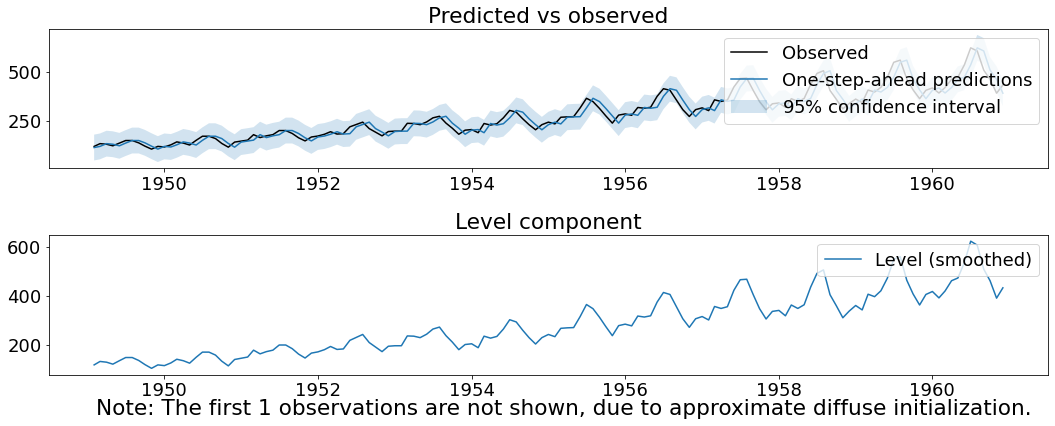

In [21]:
# ローカルレベルモデルの推定
mod_local_level = sm.tsa.UnobservedComponents(ts, 'local level')

# 最尤法によるパラメタの推定
res_local_level = mod_local_level.fit(method='nm')

# 推定されたパラメタ一覧
print(res_local_level.summary())

# 推定された状態・トレンドの描画
fig = res_local_level.plot_components()
plt.tight_layout()